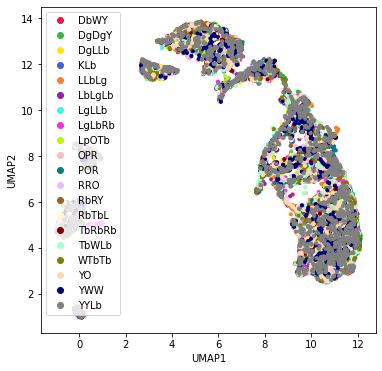

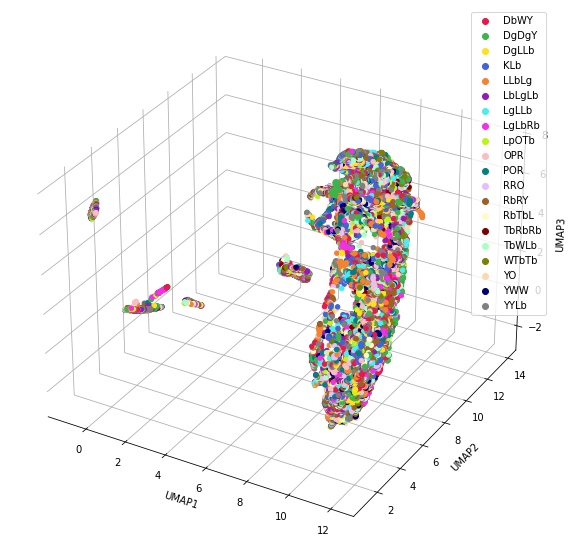

Found 3 UMAP columns in df, using all  3  for subsequent analyses.
Evaluation score S (unweighted average of same-class probability P for all classes): 18.015
Evaluation score Snorm (unweighted average of normalized same-class probability Pnorm for all classes):: 1.895


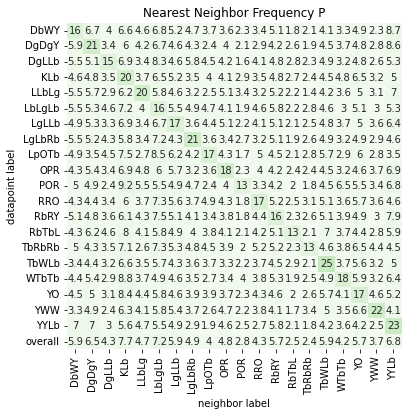

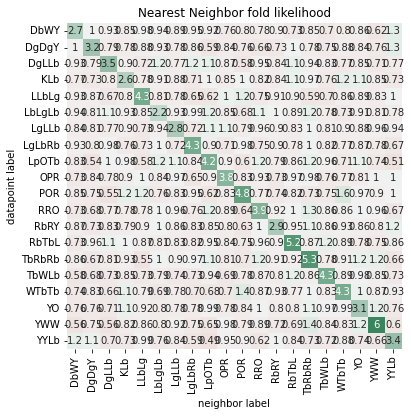

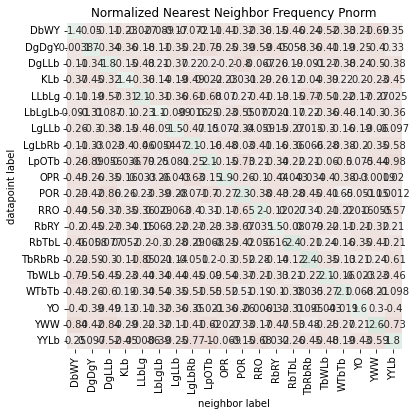

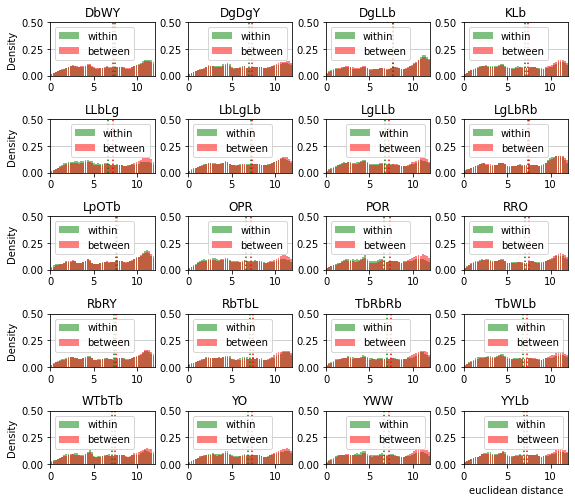

In [ ]:
import librosa
import librosa.display
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import random
import scipy
import seaborn as sns
import sys

from functions.plot_functions import umap_2Dplot, umap_3Dplot, plotly_viz
from functions.preprocessing_functions import calc_zscore, pad_spectro
from functions.evaluation_functions import plot_within_without
from functions.evaluation_functions import nn, sil
from IPython.display import Image
from pandas.core.common import flatten
from path import CWD, DATA
from pathlib import Path
from scipy.spatial.distance import pdist, squareform
from sklearn.neighbors import NearestNeighbors
from parameters.spec_params import FMIN, FMAX, FFT_WIN, FFT_HOP


P_DIR = str(CWD)

#  path to dataframe with UMAP coordinates
DF_PATH = DATA.joinpath('df_umap.pkl')


# column with label identifier
LABEL_COL = 'label'

NA_INDICATOR = "unknown"

distinct_colors_20 = [
    '#e6194b',
    '#3cb44b',
    '#ffe119',
    '#4363d8',
    '#f58231',
    '#911eb4',
    '#46f0f0',
    '#f032e6',
    '#bcf60c',
    '#fabebe',
    '#008080',
    '#e6beff',
    '#9a6324',
    '#fffac8',
    '#800000',
    '#aaffc3',
    '#808000',
    '#ffd8b1',
    '#000075',
    '#808080',
    '#ffffff',
    '#000000'
]

# Load dataframe
df = pd.read_pickle(DF_PATH)

# labels
labels = df[LABEL_COL]

umap_2Dplot(
    x=df['UMAP1'],                  # xaxis coordinates
    y=df['UMAP2'],                  # yaxis coordinates
    scat_labels=labels,             # labels (if available)
    mycolors=distinct_colors_20,    # sns.Palette color scheme name or list of colors
    outname=None,                   # filename (with path) where figure will be saved. Default: None -> figure not saved
    showlegend=True                 # show legend if True else no legend
)

plt.show()

umap_3Dplot(
    x=df['UMAP1'],                  # xaxis coordinates
    y=df['UMAP2'],                  # yaxis coordinates
    z=df['UMAP3'],                  # zaxis coordinates
    scat_labels=labels,             # labels (if available)
    mycolors=distinct_colors_20,    # sns.Palette color scheme name or list of colors
    outname=None,                   # filename (with path) where figure will be saved. Default: None -> figure not saved
    showlegend=True                 # show legend if True else no legend
)

plt.show()

# create dataframe with only the labelled datapoints
labelled_df = df.loc[df[LABEL_COL] != NA_INDICATOR, :]

# detects UMAP columns
UMAP_COLS = [x for x in labelled_df.columns if 'UMAP' in x]
print("Found", len(UMAP_COLS), "UMAP columns in df, using all ",len(UMAP_COLS)," for subsequent analyses.")

labels = labelled_df[LABEL_COL]                # manual labels
embedding = np.asarray(labelled_df[UMAP_COLS]) # UMAP coordinates

knn = 5 #  for knn=5 nearest neighbors

nn_stats = nn(embedding, np.asarray(labels), k=knn)

# Summary scores
print("Evaluation score S (unweighted average of same-class probability P for all classes):",round(nn_stats.get_S(),3))
print("Evaluation score Snorm (unweighted average of normalized same-class probability Pnorm for all classes)::", round(nn_stats.get_Snorm(),3))

nn_stats.plot_heat_S(
    vmin=0,                         # lower end (for color scheme)
    vmax=100,                       # upper end (for color scheme)
    center=50,                      # center(for color scheme)
    cmap=sns.color_palette(         # color scheme
        "Greens",
        as_cmap=True
    ),
    cbar=None,                      # show colorbar if True else don't
    outname=None                    # filename (with path) where figure will be saved. Default: None -> figure not saved
)

nn_stats.plot_heat_fold(
    center=1,                       # center(for color scheme)
    cmap=sns.diverging_palette(     # color scheme
        20,
        145,
        as_cmap=True
    ),
    cbar=None,                      # show colorbar if True else don't
    outname=None                    # filename (with path) where figure will be saved. Default: None -> figure not saved
)

nn_stats.plot_heat_Snorm(
    vmin=-13,       # lower end (for color scheme)
    vmax=13,        # upper end (for color scheme)
    center=1,       # center(for color scheme)
    cmap=sns.diverging_palette( # color scheme
        20,
        145,
        as_cmap=True
    ),
    cbar=None,      # show colorbar if True else don't
    outname=None    # filename (with path) where figure will be saved. Default: None -> figure not saved
)

plot_within_without(
    embedding=embedding,         # latent space coordinates (2D numpy array)
    labels=labels,               # calltype labels
    distance_metric='euclidean', # distance metric (all scipy distance metrics are valid)
    outname=None,                # filename (with path) where figure will be saved. Default: None -> figure not saved
    xmin=0,
    xmax=12,                     # xaxis minimum and maximum
    ymax=0.5,                    # yaxis maximum
    nbins=50,                    # number of bins
    nrows=6,                     # number of rows of subplots
    ncols=4,                     # number of cols of subplots
    density=True                 # plot density if True else plot frequency
)

plt.show()

sil_stats = sil(embedding, labels)

# filename (with path) where figure will be saved.
# Default: None -> figure not saved
sil_stats.plot_sil(outname=None)

sil_stats.get_avrg_score()

DISPLAY_COL = 'spectrograms'  # which spectrograms to display
                              # could also choose denoised_spectrograms or other

knn = 5

# Find k nearest neighbors
nbrs = NearestNeighbors(
    metric='euclidean',
    n_neighbors=knn+1,
    algorithm='brute'
).fit(embedding)

distances, indices = nbrs.kneighbors(embedding)

# need to remove the first neighbor, because that is the datapoint itself
indices = indices[:, 1:]
distances = distances[:, 1:]

# Randomly choose 10 calls and plot their 4 nearest neighbors
# using LIBROSA.DISPLAY

n_examples = 8
fig = plt.figure(
    figsize=(20, 20)
)
k = 1

# randomly choose
random.seed(1)
example_indices = random.sample(
    list(
        range(embedding.shape[0])
    ),
    n_examples
)

for i, ind in enumerate(example_indices):
    # Plot the random example spectrogram

    img_of_interest = labelled_df.iloc[ind, :][DISPLAY_COL]
    embedding_of_interest = embedding[ind, :]
    plt.subplot(n_examples, knn + 1, k)
    sr = labelled_df.iloc[ind, :].samplerate_hz

    librosa.display.specshow(
        img_of_interest,
        sr=sr,
        hop_length=int(FFT_HOP * sr),
        fmin=FMIN,
        fmax=FMAX,
        y_axis='mel',
        x_axis='s',
        cmap='viridis'
    )

    k = k + 1

    nearest_neighbors = indices[ind]
    for neighbor in nearest_neighbors:

        neighbor_embedding = embedding[neighbor,:]
        dist_to_original = scipy.spatial.distance.euclidean(
            embedding_of_interest,
            neighbor_embedding
        )
        neighbor_img = labelled_df.iloc[neighbor, :][DISPLAY_COL]

        plt.subplot(n_examples, knn + 1, k)
        sr = labelled_df.iloc[neighbor,:].samplerate_hz
        librosa.display.specshow(
            neighbor_img,
            sr=sr,
            hop_length=int(FFT_HOP * sr),
            fmin=FMIN, fmax=FMAX, y_axis='mel',
            x_axis='s',
            cmap='viridis'
        )

        k = k + 1

plt.tight_layout()


# Randomly choose 10 calls and plot their 4 nearest neighbors
# using PLT.IMSHOW

n_examples = 8
major_tick_interval = 20
f_to_s = FFT_HOP
rotate_x = 0

fig = plt.figure(
    figsize=(20, 20)
)
k = 1

# randomly choose
random.seed(1)
example_indices = random.sample(
    list(
        range(embedding.shape[0])
    ),
    n_examples
)

# Adjust! This is specific to your N_MELS and samplerate!
freq_label_list = [
    '512',
    '1024',
    '2048'
]


for i, ind in enumerate(example_indices):

    # Plot the random example spectrogram

    img_of_interest = labelled_df.iloc[ind, :][DISPLAY_COL]
    embedding_of_interest = embedding[ind, :]
    plt.subplot(n_examples, knn + 1, k)

    # Align specs to left
    ax = plt.gca()
    ax.set_anchor('W')
    plt.imshow(
        img_of_interest,
        interpolation='nearest',
        origin='lower',
        aspect='equal'
    )

    # Set axis ticks and labels

    # set major ticks in 0.5s steps
    major_xticks = np.arange(
        0,
        img_of_interest.shape[1],
        major_tick_interval
    )

    major_xtick_labels = ["" for x in major_xticks]

    major_yticks = [10,20,30]
    major_ytick_labels = freq_label_list

    # If lowest row, add x tick labels
    if i == (n_examples - 1):
        major_xtick_labels = [round(x*f_to_s, 2) for x in major_xticks]
        plt.xlabel('Time (s)')

    plt.ylabel('Hz')
    plt.xticks(major_xticks, major_xtick_labels, rotation=rotate_x)
    plt.yticks(major_yticks, major_ytick_labels,)

    k = k + 1

    nearest_neighbors = indices[ind]
    for neighbor in nearest_neighbors:

        neighbor_embedding = embedding[neighbor, :]
        dist_to_original = scipy.spatial.distance.euclidean(
            embedding_of_interest,
            neighbor_embedding
        )

        neighbor_img = labelled_df.iloc[neighbor, :][DISPLAY_COL]

        plt.subplot(n_examples, knn + 1, k)
        plt.imshow(
            neighbor_img,
            interpolation='nearest',
            origin='lower',
            aspect='equal'
        )

        # Align specs to the left
        ax = plt.gca()
        ax.set_anchor('W')

        # set major ticks in 0.5s steps
        major_xticks = np.arange(
            0,
            neighbor_img.shape[1],
            major_tick_interval
        )

        major_xtick_labels = ["" for x in major_xticks]

        major_yticks = [10, 20, 30]
        major_ytick_labels = ["" for x in major_yticks]

        if k >= (n_examples * (knn + 1) - knn):
            major_xtick_labels = [round(x * f_to_s, 2) for x in major_xticks]
            plt.xlabel('Time (s)')

        plt.xticks(major_xticks, major_xtick_labels, rotation=rotate_x)

        k = k + 1


# filename (with path) where figure will be saved. Default: None -> figure not saved
G = nn_stats.draw_simgraph(outname = None)

# show graph inline:
Image(G.draw(format='png',prog='neato'), width=400, height=600)

